# Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords, stopwords
import re
import seaborn as sns
from matplotlib import pyplot as plt
from keras import Sequential
from keras.layers import Embedding, LSTM, add, multiply, Conv1D, GlobalAveragePooling1D, MaxPooling1D, Lambda, Flatten, Dense, Input, merge, concatenate, Dropout, BatchNormalization
from keras import Model
from keras.initializers import Constant
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot, Tokenizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from qqp_utils import *
from keras.callbacks import EarlyStopping
from collections import Counter
import itertools
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
import keras.backend as K
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# EDA

In [7]:
train_df.shape

(404290, 6)

In [4]:
train_df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Distribution of Target Class 

In [5]:
train_df["is_duplicate"].value_counts(normalize = True)

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64

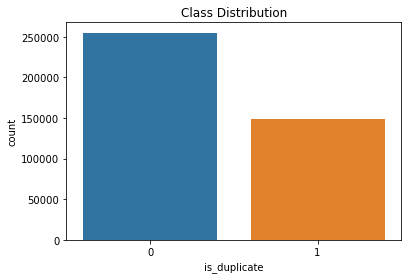

In [6]:
ax = sns.countplot(train_df["is_duplicate"])
ax.set_title("Class Distribution");

## Questions Analysis 

In [96]:
train_df.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [97]:
train_df["question1"] = train_df["question1"].astype(str)
train_df["question2"] = train_df["question2"].astype(str)

In [98]:
max(train_df["question2"].apply(len))

1169

### Distribution of Questions 

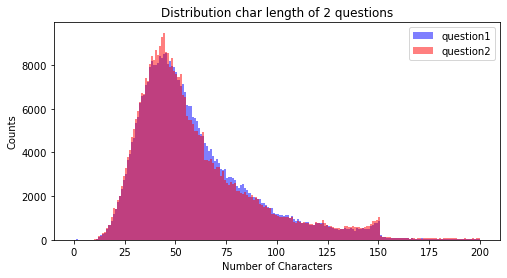

In [99]:
plt.figure(figsize = (8,4))
plt.hist(train_df["question1"].apply(len), bins = 200, range = [0,200], color = "b", alpha = 0.5)
plt.hist(train_df["question2"].apply(len), bins = 200, range = [0,200], color = "r", alpha = 0.5)
plt.title("Distribution char length of 2 questions")
plt.xlabel("Number of Characters")
plt.ylabel("Counts")
plt.legend(["question1", "question2"]);

The 2 questions have almost identical distribution  in terms of number of characters

### Distribution of difference in lengths by class 

In [100]:
len1 = train_df["question1"].apply(len)
len2 = train_df["question2"].apply(len)
diff_len = np.abs(len1-len2) 

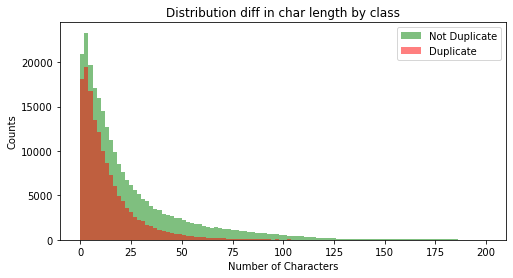

In [101]:
plt.figure(figsize = (8,4))
plt.hist(diff_len[train_df["is_duplicate"]==0], bins = 100, range = [0,200], color = "g", alpha =0.5)
plt.hist(diff_len[train_df["is_duplicate"]==1], bins = 100, range = [0,200], color = "r", alpha = 0.5)
plt.title("Distribution diff in char length by class")
plt.xlabel("Number of Characters")
plt.ylabel("Counts")
plt.legend(["Not Duplicate", "Duplicate"]);

Duplicate class the difference between characters is less 

# Cleaning & Lemmatizing the Data 

## Cleaning
Steps:
- Lowercase
- Tokenize
- Remove Stopwords
- Remove non alpha numeric characters

In [102]:
def clean_data(text):
    text = text.lower()
    words = nltk.word_tokenize(text)
    words = [w for w in words if w not in stopwords.words("english") and w.isalnum()]
    return words

In [ ]:
q1 = train_df["question1"].apply(clean_data)
q2 = train_df["question2"].apply(clean_data)

### Lemmatize

In [ ]:
lemma = WordNetLemmatizer()
def lemmatize(text):
    return [lemma.lemmatize(w) for w in text]    

In [ ]:
q1_lem = q1.apply(lemmatize)
q2_lem = q2.apply(lemmatize) 

In [ ]:
q1_sent = q1_lem.apply(" ".join)
q2_sent = q2_lem.apply(" ".join)

In [104]:
RANDOM_STATE = 24
ind_train , ind_test, y_train, y_test = train_test_split(np.arange(0,train_df.shape[0]), train_df["is_duplicate"], train_size = 0.95, stratify = train_df["is_duplicate"], random_state = RANDOM_STATE)

In [ ]:
X_clean = pd.DataFrame({"q1":q1_sent, "q2":q2_sent})
X_train, X_test = X_clean.iloc[ind_train, :], X_clean.iloc[ind_test, :]
X_clean.to_csv("X_clean.csv", index = False)

In [134]:
X_clean = pd.read_csv("X_clean.csv")
X_clean["q1"] = X_clean["q1"].apply(str)
X_clean["q2"] = X_clean["q2"].apply(str)
X_train, X_test = X_clean.iloc[ind_train, :], X_clean.iloc[ind_test, :]

# Predictive Modeling

## Difference in char length  & Char count similarity Approach
- Count characters (2-6)
- Find cosine similarity between 2 questions' char counts
- Apply predictive models with cosine similarity and length difference between questions as features

### Diff Lengths 

In [119]:
diff_len_train = diff_len[ind_train]
diff_len_test = diff_len[ind_test]

### Char Counts

In [135]:
Questions_train = pd.concat([X_train["q1"], X_train["q2"]], axis = 0)

In [ ]:
count_vect = CountVectorizer(analyzer = "char", ngram_range = (2,6))
count_vect.fit(Questions_train);

In [ ]:
charc_q1_train = count_vect.transform(X_train["q1"])
charc_q2_train = count_vect.transform(X_train["q2"])
charc_q1_test = count_vect.transform(X_test["q1"])
charc_q2_test = count_vect.transform(X_test["q2"])

### Cosine Similarity

In [ ]:
def cosine_sim(vect1, vect2):
    cos_sim = np.empty([vect1.shape[0], 1])
    for i,vs in enumerate(zip(vect1, vect2)):
        cos_sim[i] = (float(cosine_similarity(vs[0], vs[1])))
    return cos_sim

In [ ]:
cos_sim_train = cosine_sim(charc_q1_train, charc_q2_train)
pd.DataFrame({"cos_sim":list(cos_sim_train[:,0])}).to_csv("cos_sim_train.csv", index = False)

In [121]:
#cos_sim_train = pd.read_csv("cos_sim_train.csv")

In [122]:
cos_sim_train = np.array(pd.read_csv("cos_sim_train.csv"))

In [45]:
cos_sim_test = cosine_sim(charc_q1_test, charc_q2_test)
pd.DataFrame({"cos_sim":list(cos_sim_test[:,0])}).to_csv("cos_sim_test.csv", index = False)

In [123]:
#cos_sim_test = pd.read_csv("cos_sim_test.csv")

In [124]:
cos_sim_test = np.array(pd.read_csv("cos_sim_test.csv"))

### Combining Features
- Combine diff_len and cos_sim with char counts as 2 feature for the model

In [193]:
Features_train = pd.DataFrame({"diff_len": diff_len_train, "cos_sim": list(cos_sim_train)})
Features_test = pd.DataFrame({"diff_len": diff_len_test, "cos_sim": list(cos_sim_test)})

In [194]:
scaler = MinMaxScaler()
scaler.fit(Features_train)
Features_train_n = scaler.transform(Features_train)
Features_test_n = scaler.transform(Features_test)

### Modeling 

#### Logistic Regression

In [26]:
Summary_CS = pd.DataFrame(columns = ["Model", "Log Loss","Accuracy"])

In [27]:
lr = LogisticRegression()
lr.fit(Features_train_n , y_train);

In [28]:
preds_train = lr.predict_proba(Features_train_n)[:,1]

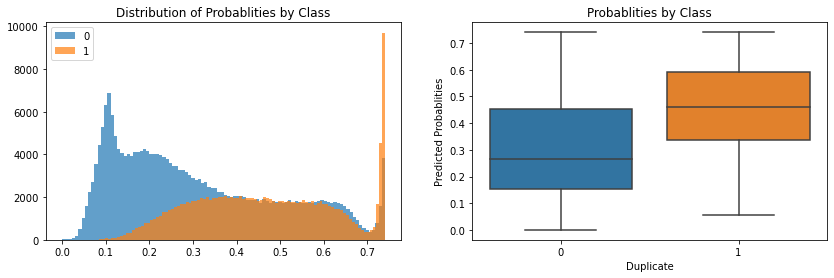

In [29]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [30]:
preds_test = lr.predict_proba(Features_test_n)[:,1]
log_loss_score = log_loss(y_test, preds_test)
accuracy = lr.score(Features_test_n, y_test)

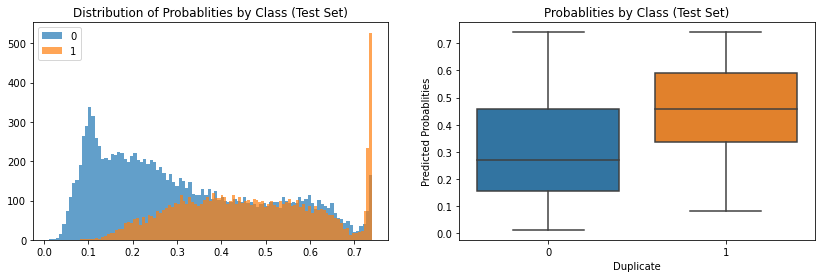

In [31]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [32]:
Summary_CS  = Summary_CS.append({"Model":"Diff_len & Char_counts with Logistic Regression", "Log Loss":np.round(log_loss_score,2), "Accuracy":np.round(accuracy,2)}, ignore_index = True)

In [33]:
Summary_CS

,Model,Log Loss,Accuracy
0,Diff_len & Char_counts with Logistic Regression,0.57,0.65


#### Random Forest 

In [34]:
rf = RandomForestClassifier(max_depth = 5)
rf.fit(Features_train_n , y_train);

In [35]:
preds_train = rf.predict_proba(Features_train_n)[:,1]

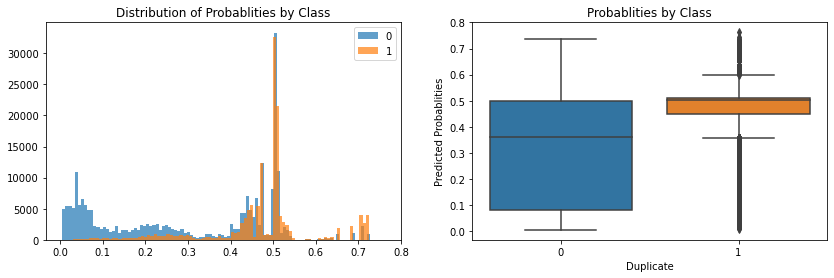

In [36]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [37]:
preds_test = rf.predict_proba(Features_test_n)[:,1]
log_loss_score = log_loss(y_test, preds_test)
accuracy = rf.score(Features_test_n, y_test)

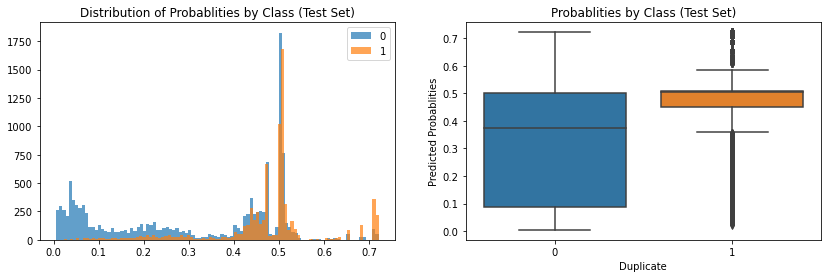

In [38]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [39]:
Summary_CS  = Summary_CS.append({"Model":"Diff_len & Char_counts with Random Forest", "Log Loss":np.round(log_loss_score,2), "Accuracy":np.round(accuracy,2)}, ignore_index = True)

In [40]:
Summary_CS

,Model,Log Loss,Accuracy
0,Diff_len & Char_counts with Logistic Regression,0.57,0.65
1,Diff_len & Char_counts with Random Forest,0.55,0.68


#### XGBoost 

In [68]:
xgb = XGBClassifier(max_depth = 5)
xgb.fit(Features_train_n , y_train);

In [69]:
preds_train = xgb.predict_proba(Features_train_n)[:,1]

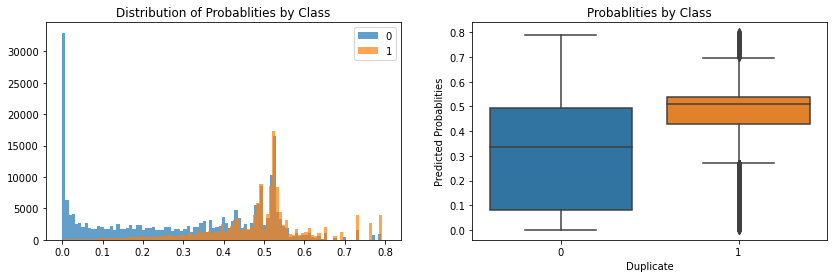

In [70]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [71]:
preds_test = xgb.predict_proba(Features_test_n)[:,1]
log_loss_score = log_loss(y_test, preds_test)
accuracy = xgb.score(Features_test_n, y_test)

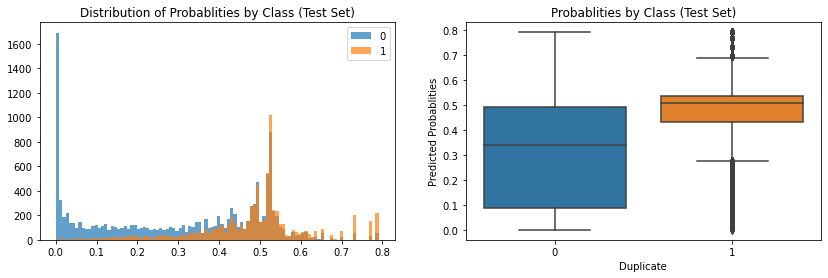

In [72]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [73]:
Summary_CS  = Summary_CS.append({"Model":"Diff_len & Char_counts with XGBoost", "Log Loss":np.round(log_loss_score,2), "Accuracy":np.round(accuracy,2)}, ignore_index = True)

In [74]:
Summary_CS

,Model,Log Loss,Accuracy
0,Diff_len & Char_counts with Logistic Regression,0.57,0.65
1,Diff_len & Char_counts with Random Forest,0.55,0.68
2,Diff_len & Char_counts with XGBoost,0.54,0.68


## Difference in char length & Tf-idf cosine similarity Approach
- Tf-idf characters (2-6)
- Find cosine similarity between 2 questions' Tf-idf vectors
- Apply predictive models with cosine similarity and length difference between questions as features

### Tf-idf

In [75]:
tfidf_vect = TfidfVectorizer(analyzer = "char", ngram_range = (2,6))
tfidf_vect.fit(Questions_train);

In [76]:
tfidf_q1_train = tfidf_vect.transform(X_train["q1"])
tfidf_q2_train = tfidf_vect.transform(X_train["q2"])
tfidf_q1_test = tfidf_vect.transform(X_test["q1"])
tfidf_q2_test = tfidf_vect.transform(X_test["q2"])

### Cosine Similarity 

In [80]:
cos_sim_train2 = cosine_sim(tfidf_q1_train, tfidf_q2_train)
pd.DataFrame({"cos_sim":list(cos_sim_train2[:,0])}).to_csv("cos_sim_train2.csv", index = False)

In [82]:
cos_sim_test2 = cosine_sim(tfidf_q1_test, tfidf_q2_test)
pd.DataFrame({"cos_sim":list(cos_sim_test2[:,0])}).to_csv("cos_sim_test2.csv", index = False)

### Combining Features
- Combine diff_len and cos_sim with char counts as 2 feature for the model

In [83]:
Features_train2 = pd.DataFrame({"diff_len": diff_len_train, "cos_sim": list(cos_sim_train2)})
Features_test2 = pd.DataFrame({"diff_len": diff_len_test, "cos_sim": list(cos_sim_test2)})

In [84]:
scaler = MinMaxScaler()
scaler.fit(Features_train)
Features_train_n2 = scaler.transform(Features_train2)
Features_test_n2 = scaler.transform(Features_test2)

### Modeling

#### Logistic Regression

In [85]:
lr = LogisticRegression()
lr.fit(Features_train_n2 , y_train);

In [86]:
preds_train = lr.predict_proba(Features_train_n2)[:,1]

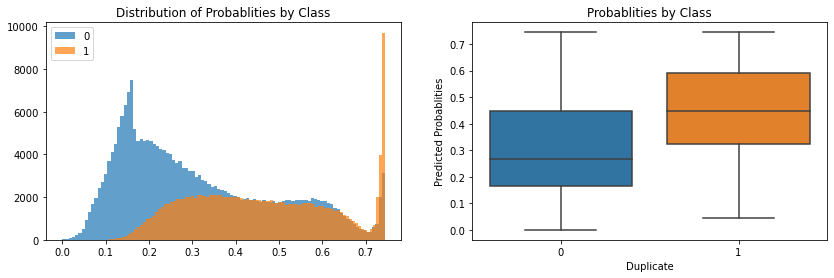

In [87]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [88]:
preds_test = lr.predict_proba(Features_test_n2)[:,1]
log_loss_score = log_loss(y_test, preds_test)
accuracy = lr.score(Features_test_n2, y_test)

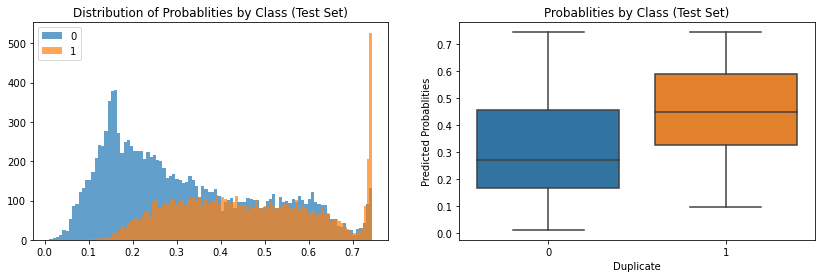

In [89]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [90]:
Summary_CS  = Summary_CS.append({"Model":"Diff_len & Tf-idf with Logistic Regression", "Log Loss":np.round(log_loss_score,2), "Accuracy":np.round(accuracy,2)}, ignore_index = True)

#### Random Forest 

In [91]:
rf = RandomForestClassifier(max_depth = 5)
rf.fit(Features_train_n2 , y_train);

In [92]:
preds_train = rf.predict_proba(Features_train_n2)[:,1]

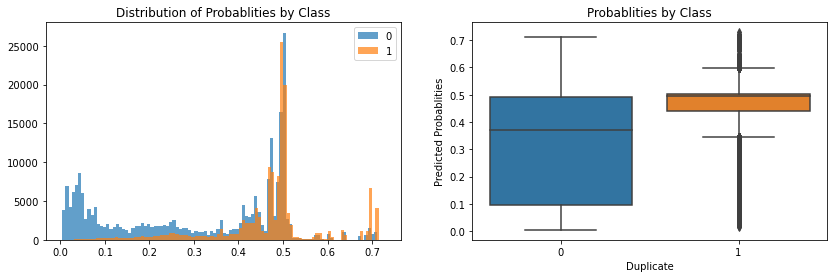

In [93]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [94]:
preds_test = rf.predict_proba(Features_test_n2)[:,1]
log_loss_score = log_loss(y_test, preds_test)
accuracy = rf.score(Features_test_n2, y_test)

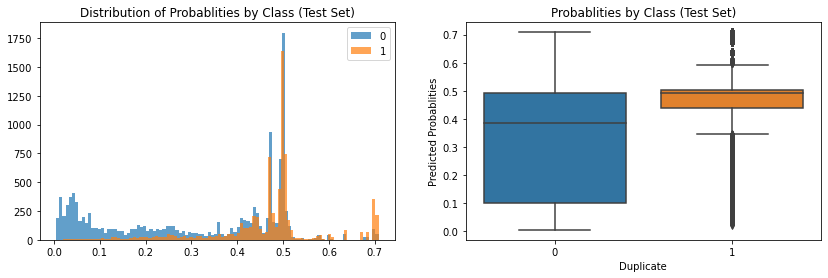

In [95]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [96]:
Summary_CS  = Summary_CS.append({"Model":"Diff_len & Tf-idf with Random Forest", "Log Loss":np.round(log_loss_score,2), "Accuracy":np.round(accuracy,2)}, ignore_index = True)

In [97]:
Summary_CS

,Model,Log Loss,Accuracy
0,Diff_len & Char_counts with Logistic Regression,0.57,0.65
1,Diff_len & Char_counts with Random Forest,0.55,0.68
2,Diff_len & Char_counts with XGBoost,0.54,0.68
3,Diff_len & Tf-idf with Logistic Regression,0.58,0.65
4,Diff_len & Tf-idf with Random Forest,0.55,0.67


#### XGBoost 

In [98]:
xgb = XGBClassifier(max_depth = 5)
xgb.fit(Features_train_n2 , y_train);

In [99]:
preds_train = xgb.predict_proba(Features_train_n2)[:,1]

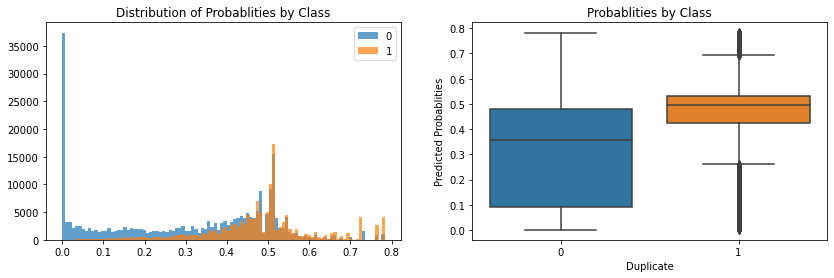

In [100]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [101]:
preds_test = xgb.predict_proba(Features_test_n2)[:,1]
log_loss_score = log_loss(y_test, preds_test)
accuracy = xgb.score(Features_test_n2, y_test)

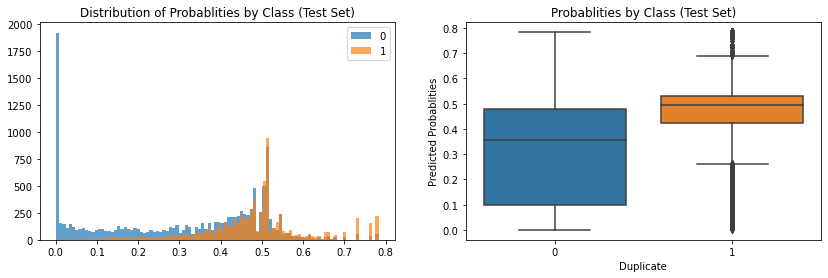

In [102]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [103]:
Summary_CS  = Summary_CS.append({"Model":"Diff_len & Tf-idf with XGBoost", "Log Loss":np.round(log_loss_score,2), "Accuracy":np.round(accuracy,2)}, ignore_index = True)

In [104]:
Summary_CS

,Model,Log Loss,Accuracy
0,Diff_len & Char_counts with Logistic Regression,0.57,0.65
1,Diff_len & Char_counts with Random Forest,0.55,0.68
2,Diff_len & Char_counts with XGBoost,0.54,0.68
3,Diff_len & Tf-idf with Logistic Regression,0.58,0.65
4,Diff_len & Tf-idf with Random Forest,0.55,0.67
5,Diff_len & Tf-idf with XGBoost,0.55,0.67


##  Sentence Embedding with Neural Networks  Approach
- Use pre trained Glove word embeddings
- Calculate average word embeddings for sentences from words
- Build a Neural Network Architecture

### Import Glove word embeddings 

In [78]:
def read_glove_vecs(glove_file):
    with open(glove_file, encoding='utf8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [79]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [80]:
def get_glove_vec(word):
    try:
        return word_to_vec_map[word]
    except:
        return np.zeros((50,))

### Calculate average word embeddings for sentences from words

In [108]:
def sentence_to_avg(sentence, word_to_vec_map = word_to_vec_map):
    words = sentence.split()
    avg = np.zeros((50))
    total = 0
    for w in words:
        total += get_glove_vec(w)
    if len(words) != 0:
        avg = total/(len(words))
    return list(avg)

### Build the Neural Network Architecture

In [150]:
X_train_emb_q1 = np.stack(X_train["q1"].apply(sentence_to_avg), axis = 0)
X_train_emb_q2 = np.stack(X_train["q2"].apply(sentence_to_avg), axis = 0);

NameError: name 'sentence_to_avg' is not defined

In [110]:
X_test_emb_q1 = np.stack(X_test["q1"].apply(sentence_to_avg), axis = 0)
X_test_emb_q2 = np.stack(X_test["q2"].apply(sentence_to_avg), axis = 0)

In [275]:
early_stopping = EarlyStopping(monitor="val_loss", patience = 5)

In [112]:
input_q1 = Input(shape = (50,), name = "Input_q1")
input_q2 = Input(shape = (50,), name = "Input_q2")

In [113]:
merge_q = concatenate([input_q1, input_q2], name = "Inputs_merged")
merge_q = Dense(128, activation='relu', name = "Dense1")(merge_q)
merge_q = BatchNormalization(name = "BatchNorm1")(merge_q)
merge_q = Dropout(0.2, name = "DropOut1")(merge_q)
merge_q = Dense(64, activation='relu', name = "Dense2")(merge_q)
merge_q = BatchNormalization(name = "BatchNorm2")(merge_q)
merge_q = Dropout(0.2, name = "DropOut2")(merge_q)

In [114]:
output = Dense(1, activation='sigmoid', name = "Output")(merge_q)

In [115]:
model = Model(inputs=[input_q1,input_q2], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [116]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_q1 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
Input_q2 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
Inputs_merged (Concatenate)     (None, 100)          0           Input_q1[0][0]                   
                                                                 Input_q2[0][0]                   
__________________________________________________________________________________________________
Dense1 (Dense)                  (None, 128)          12928       Inputs_merged[0][0]        

In [117]:
model.fit([X_train_emb_q1,X_train_emb_q2], np.array(y_train),  validation_data = ([X_test_emb_q1,X_test_emb_q2], np.array(y_test)),  epochs=200, batch_size=1024, shuffle=True, callbacks = [early_stopping])

Train on 384075 samples, validate on 20215 samples
Epoch 1/200
384075/384075 [==============================] - 3s 8us/step - loss: 0.6076 - acc: 0.6746 - val_loss: 0.5416 - val_acc: 0.7240
Epoch 2/200
384075/384075 [==============================] - 2s 6us/step - loss: 0.5411 - acc: 0.7177 - val_loss: 0.5109 - val_acc: 0.7382
Epoch 3/200
384075/384075 [==============================] - 2s 6us/step - loss: 0.5220 - acc: 0.7300 - val_loss: 0.5004 - val_acc: 0.7483
Epoch 4/200
384075/384075 [==============================] - 2s 6us/step - loss: 0.5100 - acc: 0.7378 - val_loss: 0.4909 - val_acc: 0.7502
Epoch 5/200
384075/384075 [==============================] - 2s 6us/step - loss: 0.5009 - acc: 0.7435 - val_loss: 0.4834 - val_acc: 0.7554
Epoch 6/200
384075/384075 [==============================] - 3s 7us/step - loss: 0.4942 - acc: 0.7486 - val_loss: 0.4779 - val_acc: 0.7600
Epoch 7/200
384075/384075 [==============================] - 2s 5us/step - loss: 0.4884 - acc: 0.7520 - val_loss: 0

In [118]:
preds_train = model.predict([X_train_emb_q1,X_train_emb_q2])[:,0];

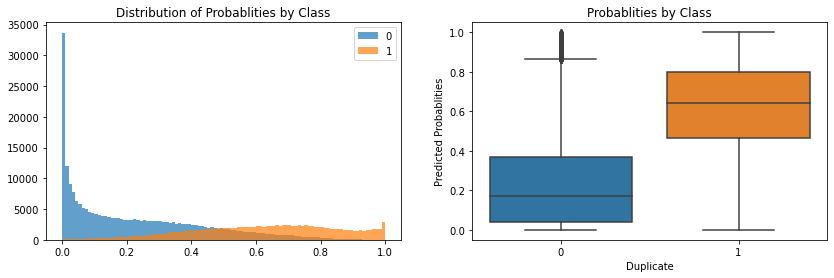

In [119]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [120]:
preds_test = model.predict([X_test_emb_q1,X_test_emb_q2])[:,0]
accuracy = accuracy_score(y_test, [1 if p > 0.5 else 0 for p in preds_test]);

In [121]:
log_loss_score = log_loss(y_test, preds_test)

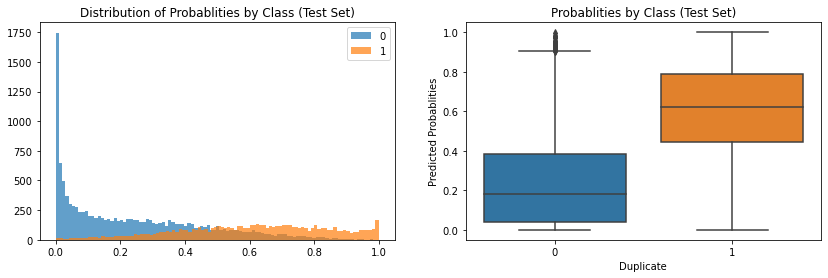

In [122]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [123]:
Summary_CS  = Summary_CS.append({"Model":"Avg. Word Embeddings & Neural Network", "Log Loss":np.round(log_loss_score,2), "Accuracy":np.round(accuracy,2)}, ignore_index = True)

In [124]:
Summary_CS

,Model,Log Loss,Accuracy
0,Diff_len & Char_counts with Logistic Regression,0.57,0.65
1,Diff_len & Char_counts with Random Forest,0.55,0.68
2,Diff_len & Char_counts with XGBoost,0.54,0.68
3,Diff_len & Tf-idf with Logistic Regression,0.58,0.65
4,Diff_len & Tf-idf with Random Forest,0.55,0.67
5,Diff_len & Tf-idf with XGBoost,0.55,0.67
6,Avg. Word Embeddings & Neural Network,0.44,0.79


Observation:
- There is a huge improvement in the test log loss with the latest approach

##  Word Embeddings and Dense Layer
- Lemmatize both Questions
- Use pre trained Glove word embeddings in the Embedding Layer
- Build a Neural Network Architecture with the Embedding and Dense Layer

### Import Glove word embeddings 
We use the Glove word embeddings imported earlier

In [151]:
VOCAB_DIM = 50000
SENTENCE_LEN = 60

In [152]:
def filter_glove(vocab_dict, dim = 50, num_words = VOCAB_DIM):
    embedding_matrix = np.zeros((num_words+1, dim))
    for word, i in vocab_dict.items():
        embedding_vector = get_glove_vec(word)
        if i == VOCAB_DIM:
            break;
        embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
tokenizer = Tokenizer(num_words = VOCAB_DIM)
tokenizer.fit_on_texts((Questions_train))
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

In [ ]:
glove_matrix = filter_glove(tokenizer.word_index)

## Creating embedding sequence 

In [268]:
sequences_q1 = tokenizer.texts_to_sequences(X_train["q1"])
sequences_q2 = tokenizer.texts_to_sequences(X_train["q2"])

In [269]:
sequences_test_q1 = tokenizer.texts_to_sequences(X_test["q1"])
sequences_test_q2 = tokenizer.texts_to_sequences(X_test["q2"])

In [270]:
pad_q1 = pad_sequences(sequences_q1, maxlen = SENTENCE_LEN, padding = "post", value = 0)
pad_q2 = pad_sequences(sequences_q2, maxlen = SENTENCE_LEN, padding = "post", value = 0)

In [271]:
pad_test_q1 = pad_sequences(sequences_test_q1, maxlen = SENTENCE_LEN, padding = "post", value = 0)
pad_test_q2 = pad_sequences(sequences_test_q2, maxlen = SENTENCE_LEN, padding = "post", value = 0)

### Build the Neural Network Architecture

In [324]:
def lstm_model(glove_matrix):
    input_q1 = Input(shape = (SENTENCE_LEN,))
    embedding_q1 = Embedding(input_dim = VOCAB_DIM + 1, output_dim = 50, 
                         embeddings_initializer=Constant(glove_matrix), 
                         input_length=SENTENCE_LEN, trainable=False, name = "embedding_q1")(input_q1)
    input_q2 = Input(shape = (SENTENCE_LEN,))
    embedding_q2 = Embedding(input_dim = VOCAB_DIM + 1, output_dim = 50, 
                         embeddings_initializer=Constant(glove_matrix), 
                         input_length=SENTENCE_LEN, trainable=False, name = "embedding_q2")(input_q2)
    
    lstm_layers = Sequential(name = "Siamese_LSTM")
    lstm_layers.add(LSTM(64, dropout = 0.5, return_sequences = True, name = "LSTM_layer1" ))
    lstm_layers.add(LSTM(64, dropout = 0.5, name = "LSTM_layer2"))
    lstm_layers.add(Dense(64, name ="Dense_layer", activation='relu'))
    
    lstm_q1 = lstm_layers(embedding_q1)
    lstm_q2 = lstm_layers(embedding_q2)
    
    magic_input = Input(shape = (2,))
    magic_dense = Dense(64, activation = "relu")(magic_input)
    
    merge_all = concatenate([lstm_q1, lstm_q2, magic_dense], name = "Merge")
    merge_all = Dense(64, activation='relu', name = "Dense1")(merge_all)
    merge_all = BatchNormalization(name = "BatchNorm1")(merge_all)
    merge_all = Dropout(0.2, name = "DropOut1")(merge_all)
    output = Dense(1, activation='sigmoid', name = "Output")(merge_all)
    model = Model(inputs=[input_q1,input_q2,magic_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [325]:
lstm_model = lstm_model(glove_matrix)

In [327]:
lstm_model.fit([pad_q1,pad_q2,Features_train_n], y_train, validation_data = ([pad_test_q1,pad_test_q2, Features_test_n], np.array(y_test)) ,  epochs=30, batch_size=1024, shuffle=True, callbacks = [early_stopping])

Train on 384075 samples, validate on 20215 samples
Epoch 1/30
384075/384075 [==============================] - 1166s 3ms/step - loss: 0.5200 - acc: 0.7117 - val_loss: 0.5687 - val_acc: 0.6427
Epoch 2/30
384075/384075 [==============================] - 1024s 3ms/step - loss: 0.5000 - acc: 0.7301 - val_loss: 0.4825 - val_acc: 0.7458
Epoch 3/30
384075/384075 [==============================] - 1128s 3ms/step - loss: 0.4912 - acc: 0.7371 - val_loss: 0.4731 - val_acc: 0.7565
Epoch 4/30
384075/384075 [==============================] - 1064s 3ms/step - loss: 0.4850 - acc: 0.7420 - val_loss: 0.4650 - val_acc: 0.7597
Epoch 5/30
384075/384075 [==============================] - 1044s 3ms/step - loss: 0.4804 - acc: 0.7455 - val_loss: 0.4673 - val_acc: 0.7615
Epoch 6/30
384075/384075 [==============================] - 1043s 3ms/step - loss: 0.4765 - acc: 0.7487 - val_loss: 0.4620 - val_acc: 0.7610
Epoch 7/30
384000/384075 [============================>.] - ETA: 0s - loss: 0.4717 - acc: 0.7516

KeyboardInterrupt: 

In [329]:
preds_train = lstm_model.predict([pad_q1,pad_q2, Features_train_n])[: ,0];

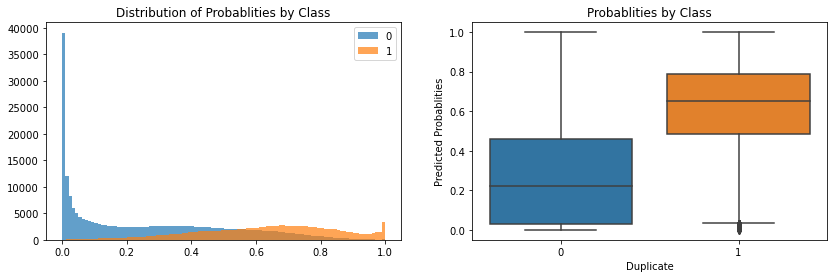

In [330]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [332]:
preds_test = lstm_model.predict([pad_test_q1,pad_test_q2,Features_test_n])[:,0];
accuracy = accuracy_score(y_test, [1 if p > 0.5 else 0 for p in preds_test]);
#preds_test[preds_test < 0.00001] = 0.00001 
#preds_test[preds_test  > 0.99999] =  0.99999

In [333]:
log_loss_score = log_loss(y_test, preds_test)

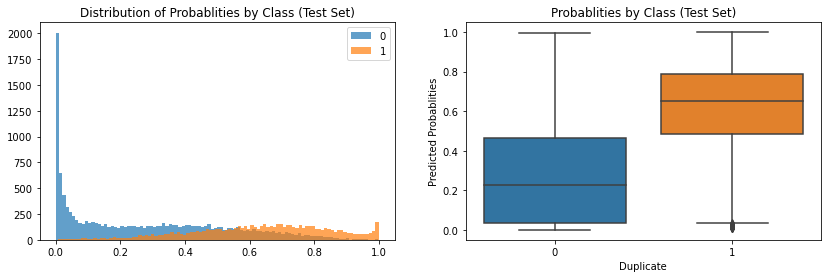

In [334]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [335]:
Summary_CS  = Summary_CS.append({"Model":"LSTM Architecture", "Log Loss":np.round(log_loss_score,2), "Accuracy":np.round(accuracy,2)}, ignore_index = True)

In [336]:
Summary_CS

,Model,Log Loss,Accuracy
0,Diff_len & Char_counts with Logistic Regression,0.57,0.65
1,Diff_len & Char_counts with Random Forest,0.55,0.68
2,Word Embeddings & Dense Neural Network,0.49,0.78
3,Word Embeddings & Dense Neural Network,0.47,0.78
4,LSTM Architecture,0.46,0.77


##  Word Embeddings and LSTM
- Use pre trained Glove word embeddings in the Embedding Layer
- Build a Neural Network Architecture with the Embedding, LSTM and Dense Layer

### Import Glove word embeddings 
We use the Glove word embeddings imported earlier

In [50]:
glove_matrix = filter_glove(tokenizer.word_index)

### Build the Neural Network Architecture

In [405]:
def cnn_arch(glove_matrix):
    input_q1 = Input(shape = (SENTENCE_LEN,))
    embedding_q1 = Embedding(input_dim = VOCAB_DIM + 1, output_dim = 50, 
                         embeddings_initializer=Constant(glove_matrix), 
                         input_length=SENTENCE_LEN, trainable=False, name = "embedding_q1")(input_q1)
    input_q2 = Input(shape = (SENTENCE_LEN,))
    embedding_q2 = Embedding(input_dim = VOCAB_DIM + 1, output_dim = 50, 
                         embeddings_initializer=Constant(glove_matrix), 
                         input_length= SENTENCE_LEN, trainable=False, name = "embedding_q2")(input_q2)
    

    
    cnn_layers2 = Sequential()
    cnn_layers2.add(Conv1D(filters=128, kernel_size=2,input_shape = (SENTENCE_LEN,50), padding='same', activation='relu')) 
    cnn_layers2.add(GlobalAveragePooling1D())
    cnn_layers2.add(BatchNormalization())
    cnn_layers2.add(Dropout(0.2))
    cnn_layers2.add(Dense(64, activation='relu'))
    cnn_layers2.add(BatchNormalization())
    cnn_layers2.add(Dropout(0.2))
    cnn_q1k2 = cnn_layers2(embedding_q1)
    cnn_q2k2 = cnn_layers2(embedding_q2)

    
    magic_input = Input(shape = (2,))
    magic_dense = Dense(64, activation = "relu")(magic_input)
    
    merge_all = concatenate([cnn_q1k2, cnn_q2k2, magic_dense])
    merge_all = Dense(128, activation='relu')(merge_all)
    merge_all = BatchNormalization()(merge_all)
    merge_all = Dropout(0.2)(merge_all)
    output = Dense(1, activation='sigmoid')(merge_all)
    model = Model(inputs=[input_q1,input_q2,magic_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])
    
    return model

In [406]:
cnn_model = cnn_arch(glove_matrix)

In [407]:
cnn_model.fit([pad_q1,pad_q2,Features_train_n], y_train, validation_data = ([pad_test_q1,pad_test_q2, Features_test_n],y_test) ,  epochs=10, batch_size=1024, shuffle=True, callbacks = [early_stopping])

Train on 384075 samples, validate on 20215 samples
Epoch 1/10
384075/384075 [==============================] - 197s 513us/step - loss: 0.5408 - acc: 0.7088 - val_loss: 0.4840 - val_acc: 0.7478
Epoch 2/10
384075/384075 [==============================] - 208s 541us/step - loss: 0.4784 - acc: 0.7482 - val_loss: 0.4628 - val_acc: 0.7667
Epoch 3/10
384075/384075 [==============================] - 208s 541us/step - loss: 0.4585 - acc: 0.7635 - val_loss: 0.4596 - val_acc: 0.7633
Epoch 4/10
384075/384075 [==============================] - 207s 538us/step - loss: 0.4480 - acc: 0.7705 - val_loss: 0.4398 - val_acc: 0.7772
Epoch 5/10
384075/384075 [==============================] - 210s 546us/step - loss: 0.4401 - acc: 0.7766 - val_loss: 0.4678 - val_acc: 0.7551
Epoch 6/10
384075/384075 [==============================] - 211s 549us/step - loss: 0.4344 - acc: 0.7798 - val_loss: 0.4382 - val_acc: 0.7768
Epoch 7/10
384075/384075 [==============================] - 210s 546us/step - loss: 0.4299 - acc:

In [389]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           (None, 60)           0                                            
__________________________________________________________________________________________________
input_48 (InputLayer)           (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_q1 (Embedding)        (None, 60, 50)       2500050     input_47[0][0]                   
__________________________________________________________________________________________________
embedding_q2 (Embedding)        (None, 60, 50)       2500050     input_48[0][0]                   
___________________________________________________________________________________________

In [266]:
preds_train = model.predict([pad_q1,pad_q2, Features_test_n]);

IndexError: index 20215 is out of bounds for axis 0 with size 20215

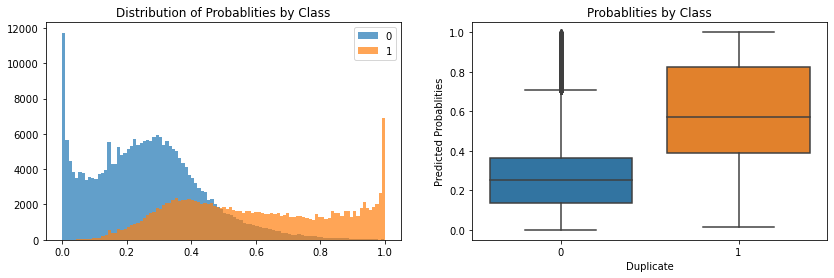

In [825]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_train[y_train==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_train[y_train==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_train, "y":y_train})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class");

In [399]:
preds_test = model.predict([pad_test_q1,pad_test_q2,Features_test_n])[:,0];
preds_test[preds_test < 0.00001] = 0.00001 

In [400]:
preds_test[preds_test  > 0.99999] =  0.99999

In [401]:
log_loss_score = log_loss(y_test, preds_test)

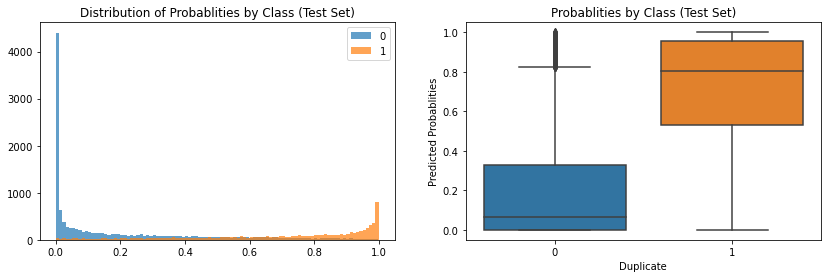

In [402]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
ax[0].hist(preds_test[y_test==0], bins = 100, alpha = 0.7)
ax[0].hist(preds_test[y_test==1], bins = 100, alpha = 0.7)
ax[0].set_title("Distribution of Probablities by Class (Test Set)")
ax[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_preds":preds_test, "y":y_test})
sns.boxplot(x="y", y="LR_preds", data = output_lr, ax = ax[1])
ax[1].set_ylabel("Predicted Probablities")
ax[1].set_xlabel("Duplicate")
ax[1].set_title("Probablities by Class (Test Set)");

In [403]:
Summary_CS  = Summary_CS.append({"Model":"Glove Embeddings & Neural Network", "Test Log Loss":np.round(log_loss_score,2)}, ignore_index = True)

In [404]:
Summary_CS

,Model,Log Loss,Accuracy,Test Log Loss
0,Diff_len & Char_counts with Logistic Regression,0.57,0.65,NaN
1,Diff_len & Char_counts with Random Forest,0.55,0.68,NaN
2,Word Embeddings & Dense Neural Network,0.49,0.78,NaN
3,Word Embeddings & Dense Neural Network,0.47,0.78,NaN
4,LSTM Architecture,0.46,0.77,NaN
5,Glove Embeddings & Neural Network,NaN,NaN,0.39
